# A.4. Swaps and SOFR

## Fixed Income Module

### DRW New-Hire Learning Program

#### Summer 2022

Questions?
* Contact: Mark Hendricks
* hendricks@uchicago.edu

In [4]:
import pandas as pd
import numpy as np
import datetime
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from scipy.optimize import minimize

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
import sys
sys.path.insert(0, '../cmds')
from utils import *

$\newcommand{\value}{V}$
$\newcommand{\price}{P}$
$\newcommand{\float}{\text{float}}$
$\newcommand{\freq}{\kappa}$
$\newcommand{\tbond}{\text{vanilla}}$
$\newcommand{\cpn}{c}$
$\newcommand{\spread}{s}$
$\newcommand{\swap}{\text{swap}}$
$\newcommand{\swaprate}{\cpn_{\swap}}$
$\newcommand{\cashflow}{C}$

# Swaps

A **swap** is an over-the-counter derivative. 
- Two counterparties agree at $t$ to swap payments on future dates.
- The payments may be based on fixed vs floating interest rates on the same currency or fixed interest rates across two currencies.
- The swap designates a **notional** base for the interest rates, but the notional is not exchanged.

### Fixed-for-Floating

A **fixed-for-floating** interest-rate swap is an agreement with the following obligations
- make fixed payments at an annualized rate, $\cpn$, on a notional $N$, up to a maturity date $T$.
- make payments derived from a variable short-term rate, $r(t)$.

Consider the swap 
- exchanging payments at frequency $n$
- thus making payments every $\Delta = 1/n$.
- the interest rate quoted is compounded at frequency $n$.

Cashflow, $\cashflow$, at each swap period is

$\begin{align}
\cashflow(T_i) = N \Delta\left[r_n(T_{i-1})-\cpn\right]
\end{align}$

### Swap Rate

The fixed rate in the fixed-for-floating swap, $c$, is known as the **swap rate**.

Note that it is specific to
- the index underlying the floating rate
- the maturity
- the frequency of payments
- the frequency of the compounding of the rates quoted

### Specifications 

Frequency
- common to see semiannual frequency of reset dates
- may see quarterly, and in theory, many frequencies are plausible

Floating rates
- floating rate bonds typically use major money-market indexes.
- in the past, LIBOR was dominant as a floating rate.
- now, SOFR and the Fed Fund Rates dominate for dollar-denominated instruments.

SOFR and the Fed Funds Rate are discussed in depth later. 
- For now, just note that these are short-term interest rates.

### Swaps vs Forwards

Note that a forward is a simple, single-date, swap.

Thus, a swap is a portfolio of forwards.


### No cost to initiate

Like a forward, there is no cost to initiate the swap.
- There is no cashflow immediately.
- The swap rate is set such that the value is initially zero.
- This is a similarity to the forward, (FRA or forward contract), where the forward rate is such that the initial value is zero.

This aspect is an important part of why swaps (and forwards) have become so important for managing interest-rate risk: they allow one to change the duration of the portfolio without any initial price.

## Swap Value

The swapped cashflow (from the perspective of the paying-fixed, receiving floating,) is replicated by holding
* $+$ Floating bond
* $-$ Fixed treasury

Thus, value is

$\begin{align}
\value_{\swap}(t,T,\swaprate) = P_{\float}(t,T;s) - P_{\tbond}(t,T;\cpn)
\end{align}$

where the frequency, $\freq$, or set of swap dates, $T_i$, are ommitted for notational simplicity.

#### Implicitly defined swap rate

The swap rate, $\swaprate$, is the value that makes the value $0$ at $t=0$:

$\begin{align}
\swaprate \text{ such that }V_{\text{Swap}}(0,T,\swaprate) = 0
\end{align}$


### Valuation

## Swap Curve

The equation above gave the swap valuation as a function of the **discount curve**. 

Observing swap rates, $c$ across various maturities, extract the **discount curve**.
- Mathematically, this is similar to extracting the discount curve form treasuries.
- Bootstrap the curve if swap rates are available at the full grid of maturities

# Secured Overnight Financing Rate (SOFR)

## Load SOFR Swap data

In [5]:
filepath = '../data/sofr_swaps.xlsx'
swaps_raw = pd.read_excel(filepath,sheet_name='data').set_index('Unnamed: 0')
swaps_raw.columns = swaps_raw.columns.astype(float)
swaps_raw.index.name = 'date'

# a few of the time-series have some obvious data errors
# eliminate them by making 99th quantile NaN
ub = swaps_raw.quantile(1)
swaps = swaps_raw[(swaps_raw < ub)]

In [6]:
tab = swaps.iloc[-1,:].to_frame().T
tabcolnames = list()
for col in tab.columns:
    tabcolnames.append(f'{col:.2f}')

tab.columns = tabcolnames

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(tab)

,0.08,0.17,0.25,0.33,0.42,0.50,0.58,0.67,0.75,0.83,0.92,1.00,1.08,1.17,1.25,1.33,1.42,1.50,1.58,1.67,1.75,1.83,1.92,2.00,2.25,2.50,2.75,3.00,4.00,5.00,6.00,7.00,8.00,9.00,10.00,15.00,20.00,25.00,30.00,40.00,50.00
2022-05-27,1.0404,1.2016,1.3928,1.5196,1.634,1.755,1.872,1.9615,2.046,2.1305,2.195,2.2608,2.317,2.3543,2.3882,2.4213,2.4455,2.4635,2.485,2.4985,2.51,2.5195,2.5295,2.5345,2.543,2.544,2.5435,2.5392,2.5127,2.4967,2.4941,2.5001,2.5078,2.5207,2.5377,2.6171,2.6126,2.5396,2.4626,2.2699,2.075


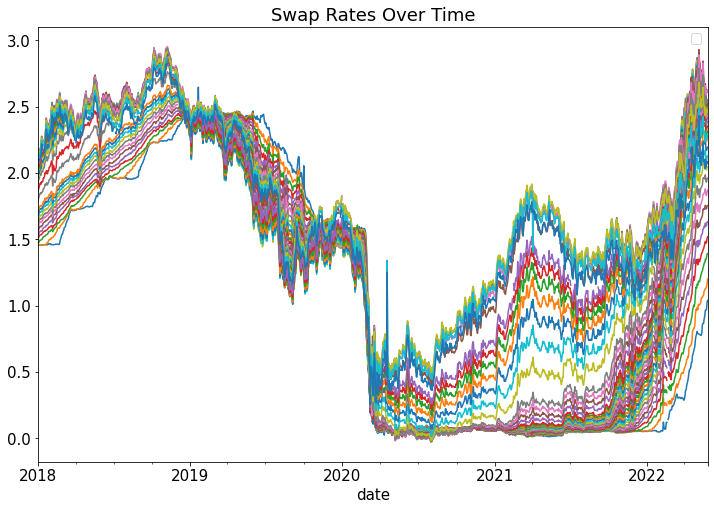

In [7]:
swaps.plot(figsize=(12,8),title='Swap Rates Over Time')
plt.legend([])
plt.show()

### SOFR Swap Curves

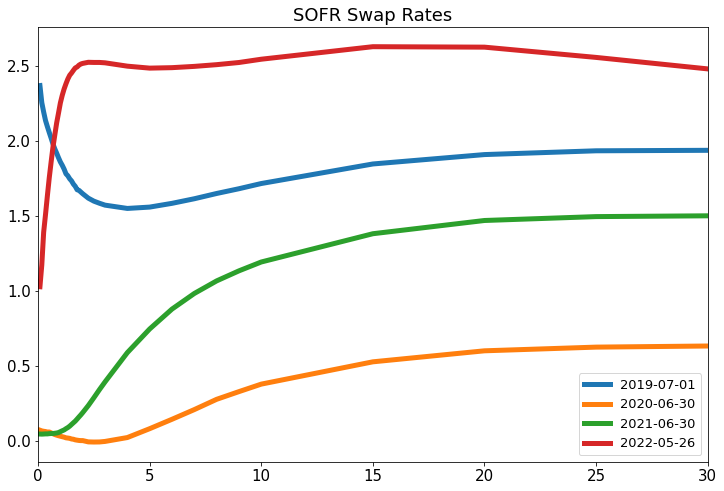

In [8]:
dtset = pd.to_datetime(['2019-06-30', '2020-06-30', '2021-06-30', '2022-05-26'])
dts = [next_business_day(i) for i in dtset]
dts_formatted = [f'{dt:%Y-%m-%d}' for dt in dts]

swaps.loc[dts,:].T.plot(figsize=(12,8),xlim=(0,30),linewidth=5,title='SOFR Swap Rates')
plt.legend(dts_formatted)
plt.show()

## References

### Why the spike in SOFR on Sep 17, 2019?
https://www.federalreserve.gov/econres/notes/feds-notes/what-happened-in-money-markets-in-september-2019-20200227.htm

https://en.wikipedia.org/wiki/September_2019_events_in_the_U.S._repo_market